,dd,captured,population,active_0,active_1,active_2,eggs_1,eggs_2
77,77,0.000862,1.894599,1.879632,0.0,0.0,0.0,0.0
100,100,1.027109,717.342592,487.259553,0.0,0.0,0.0,0.0


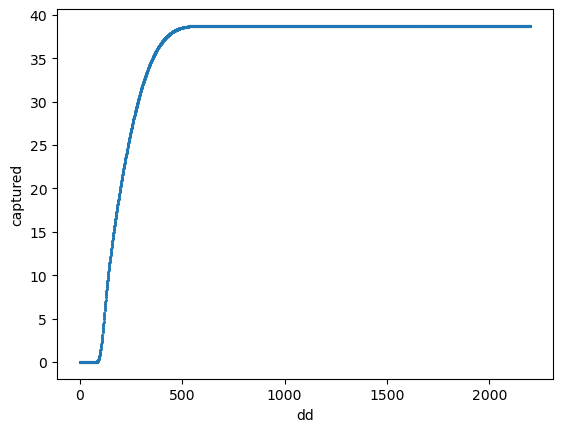

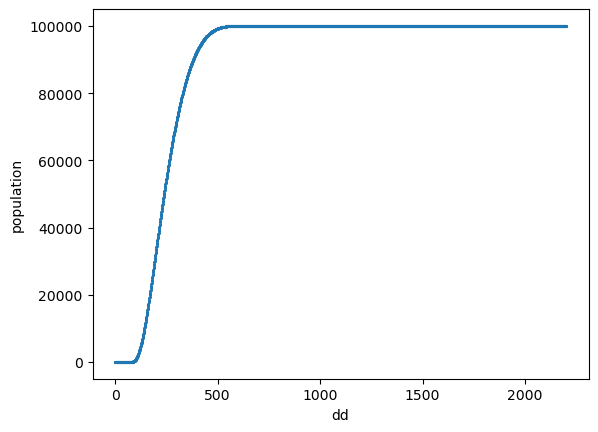

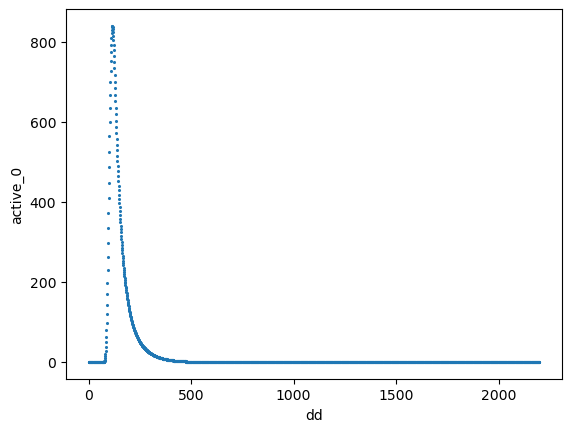

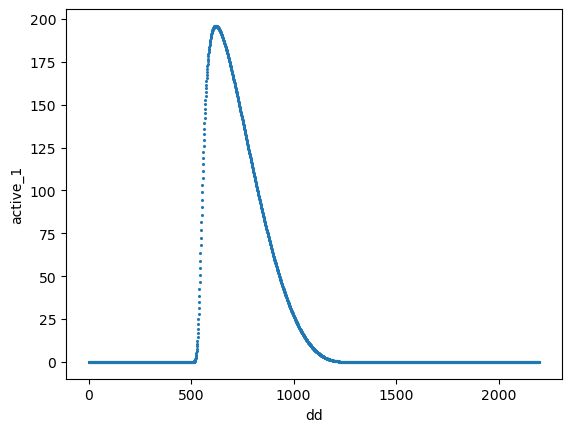

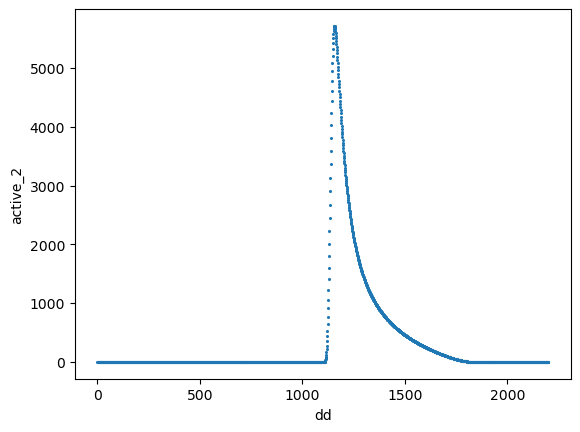

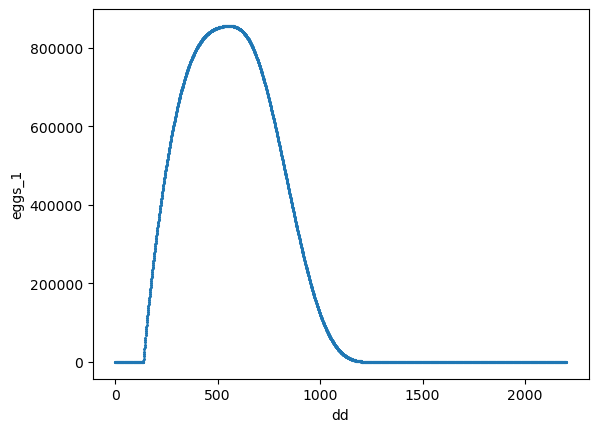

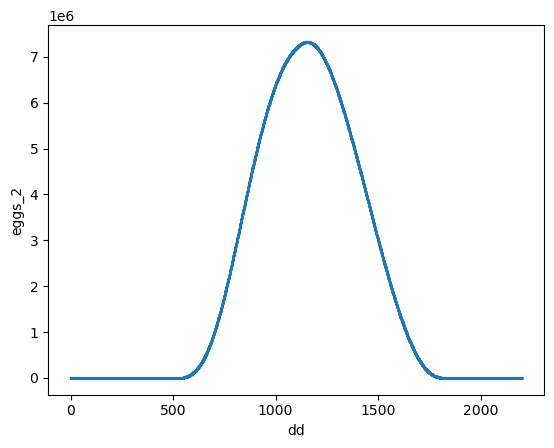

In [1]:
import pandas as pd
df = pd.read_csv('test_0.csv')
df.plot.scatter(0, 1, 1.5)
df.plot.scatter(0, 2, 1.5)
df.plot.scatter(0, 3, 1.5)
df.plot.scatter(0, 4, 1.5)
df.plot.scatter(0, 5, 1.5)
df.plot.scatter(0, 6, 1.5)
df.plot.scatter(0, 7, 1.5)
pd.concat([df[df.population >= 1].head(1), df[df.captured >= 1].head(1)])

In [2]:
(1 - (df.tail(1).eggs_1 / df.eggs_1.max()))

2200    0.999998
Name: eggs_1, dtype: float64

In [3]:
df.eggs_1.max()

856176.8923822347

In [4]:
df.tail(1).eggs_1

2200    1.307314
Name: eggs_1, dtype: float64

In [5]:
df.tail(1)

,dd,captured,population,active_0,active_1,active_2,eggs_1,eggs_2
2200,2200,38.741214,100000.0,0.0,0.0,0.0,1.307314,889.588474
